# SciPy solve_ivp example for solving 2D diffusion equation in a rectangular grid

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as widgets
import matplotlib.ticker as mticker
%matplotlib widget

## Modelled system

The modelled system is a rectangular surface of a pond. When a contaminant is spilled in the pond it will diffuse on the surface. The evolution of the contaminant concentration C is described by Fick's second law

\begin{align*}
    \frac{\partial C}{\partial t} &= D \Delta C \\
    &= D \left( \frac{\partial^2 C}{\partial x^2} + \frac{\partial^2 C}{\partial y^2} \right)
\end{align*}

where D is the diffusion coefficient of the contaminant in water

We well be using the [method of lines](http://hplgit.github.io/prog4comp/doc/pub/p4c-sphinx-Python/._pylight006.html#reduction-of-a-pde-to-a-system-of-odes) approach to transform the PDE into a system of ODEs. This is done by discretizing the spatial dimension.

We will follow the central difference scheme in the above link. The change of concentration in an element i is

\begin{equation*}
    \frac{\mathrm{d}C_{i,j}}{\mathrm{d}t} = D\left( \frac{C(x_{i+1},t) - 2C(x,t) + C(x_{i-1},t)}{(\Delta x)^2} +\frac{C(y_{i+1},t) - 2C(y,t) + C(y_{i-1},t)}{(\Delta y)^2} \right)
\end{equation*}

Finally, we need to decide what is the change of concentration at the boundaries of the rectangle (boundary conditions). For simplicity we will assume Dirichlet boundary condition and assume that the concentration at the boundary is 

\begin{equation*}
    C_{\mathrm{boundary}} = C_0
\end{equation*}

Now that we have discretized the equation we are left with $(N-2) \cdot (M-2)$ ordinary differential equations of the form

\begin{align*}
\frac{\mathrm{d}C_{1,1}}{\mathrm{d}t} &= D\left(  \frac{C_{2,1} - 2C_{1, 1} + C_{0, 1}}{(\Delta x)^2} +\frac{C_{1,2} - 2C_{1, 1} + C_{1,0}}{(\Delta y)^2} \right) \\
&\;\;\vdots \\
\frac{\mathrm{d}C_{N-1,M-1}}{\mathrm{d}t} &= D\left(  \frac{C_{N,M-1} - 2C_{N-1, M-1} + C_{N-2, M}}{(\Delta x)^2} +\frac{C_{N-1,M} - 2C_{N-1, M-1} + C_{N-1, M-2}}{(\Delta y)^2} \right)
\end{align*}

where N is the number of horizontal elements in the rectangular grid and M is the number of vertical elements. Note that in the last equations we have omitted the time subscript for simplicity. We do not need to consider the ODEs at the boundary since their concentration does not change due to the choice of the boundary conditions. If we would have needed Neumann type boundary conditions, it would have resulted to system of $(N+2) \cdot (M+2)$ ODEs

Next, we are going to solve this ODE system in domain

\begin{align*}
t &\in [0, 100] \\
\{x,y\} &\in [0, 10]
\end{align*}

with initial conditions

\begin{align*}
C_0 = 10^{-3} \\
C_{4.5,4.5 - 5.5,5.5} = 1
\end{align*}

and with the Dirichlet boundary condition specified above

## Define parameters

In [115]:
# Diffusion coefficient
D = 1e-8

# Grid resolution and max length
dx = 0.25
dy = 0.25
lx = 10
ly = 10

# Number of gridpoints
N_x = int(lx/dx) + 1
N_y = int(ly/dy) + 1

# grid point vectors
x = np.linspace(0,lx,N_x)
y = np.linspace(0,ly,N_y)

# Concentration vector of the contaminant
C = np.zeros((N_x,N_y)) + 1e-3

# Select region between(4.5,4.5)(5.5,5.5)
ind_x = np.where((x >= 4.5) & (x <=5.5))[0]
ind_y = np.where((y >= 4.5) & (y <=5.5))[0]

for ix in ind_x:
    for iy in ind_y:
        C[ix,iy] = 1


## Define RHS function of the ode system

In [72]:
def odefun(c, D, dx, dy):
    dcdt = np.zeros(c.shape)
    dcdt[1:-1, 1:-1] = D*((c[2:, 1:-1] - 2*c[1:-1, 1:-1] + c[:-2,1:-1] ) / (dx)**2 + c[1:-1, 2:] - 2*c[1:-1, 1:-1] + c[1:-1,:-2] ) / (dy)**2
    return dcdt 

In [78]:
t = odefun(C,D,dx,dy)
print(np.sum(t))

-9.926167350636332e-24


## Run solve_ivp

In [77]:
sol = solve_ivp(lambda t,c: odefun(c,D,dx,dy), (0, 50), C)

ValueError: `y0` must be 1-dimensional.

### What happened?

We ran into error ```ValueError: `y0` must be 1-dimensional.```. The error is due to the fact that our matrix C is 2-dimensional but for historical reasons related to how the solvers are programmed the ode solvers in Python and many other languages operate with one dimensional arrays. We need to reshape our initial condition matrix C into a 1-dimensional array and because the odefun must return a matrix that has the same shape as C we need to also modify the odefun

In [128]:
def odefun(c, D, dx, dy, Nx, Ny):
    conc = c.reshape(Nx,Ny)
    dcdt = np.zeros(conc.shape)
    dcdt[1:-1, 1:-1] = D*((conc[2:, 1:-1] - 2*conc[1:-1, 1:-1] + conc[:-2,1:-1] ) / (dx)**2 + (conc[1:-1, 2:] - 2*conc[1:-1, 1:-1] + conc[1:-1,:-2] ) / (dy)**2)
    return dcdt.reshape(Nx*Ny,)
C = C.reshape(N_x*N_y,)

In [201]:
sol = solve_ivp(lambda t,c: odefun(c,1e-1,dx,dy, N_x, N_y), (0, 50), C, t_eval=np.linspace(0,50, 501))
sol.y.shape

(1681, 501)

## Visualize solution

interactive(children=(IntSlider(value=1, description='Time', max=500, min=1), Output()), _dom_classes=('widget…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
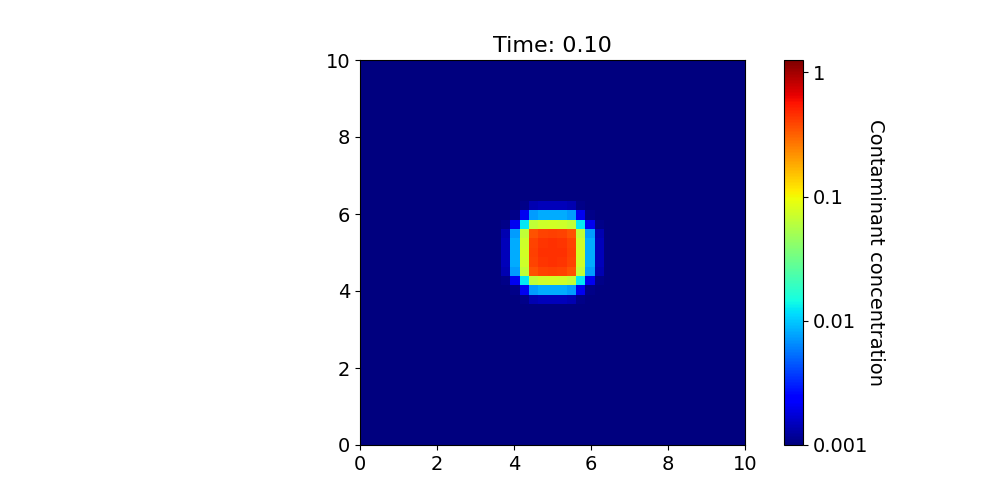

In [212]:
fig, ax = plt.subplots(figsize=(10, 5))
img2 = ax.imshow(np.random.uniform(size=(10,10)), vmin=-3, vmax=0.5, cmap='jet')
cbar = fig.colorbar(img2)
cbar.ax.set_ylabel('Contaminant concentration', rotation=270, labelpad=12, fontsize=14)
cbar.ax.set_yticks([-3, -2, -1, 0])
cbar.ax.set_yticklabels([0.001, 0.01, 0.1, 1])
cbar.ax.tick_params(axis='y', labelsize=14)


def plot_solution(Time):
    ax.clear()
    ax.imshow(np.log10(sol.y[:, Time].reshape(N_x, N_y)), interpolation='nearest',
                    cmap='jet', vmin=-3, vmax=0.5, origin='lower', extent=[0, lx, 0, ly])
    ax.set_title(f'Time: {sol.t[Time]:.2f}', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    # cbar.ax.yaxis.set_ticks_position('left')


widgets.interactive(plot_solution, Time=widgets.IntSlider(min=1, max=(len(sol.t)-1), value=0))


In [204]:
plt.close('all')